In [1]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(ggplot2)))
library(repr)
options(repr.plot.width=15, repr.plot.height=10)

In [2]:
listGeuvadis = read.table('../data/01_raw/SampleTot.txt',header = T)
hlaExp = read.table("../data/01_raw/hla_expression.tsv", sep = "\t", header = T) %>% filter(subject_id %in% listGeuvadis$subject_id)
hlaExp %>% head(3)

,subject_id,pop,sex,lab,gene_name,tpm
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,HG00096,GBR,male,UNIGE,HLA-A,1604.34
2,HG00096,GBR,male,UNIGE,HLA-B,2987.70
3,HG00096,GBR,male,UNIGE,HLA-C,1087.53


# General gene expression distributions

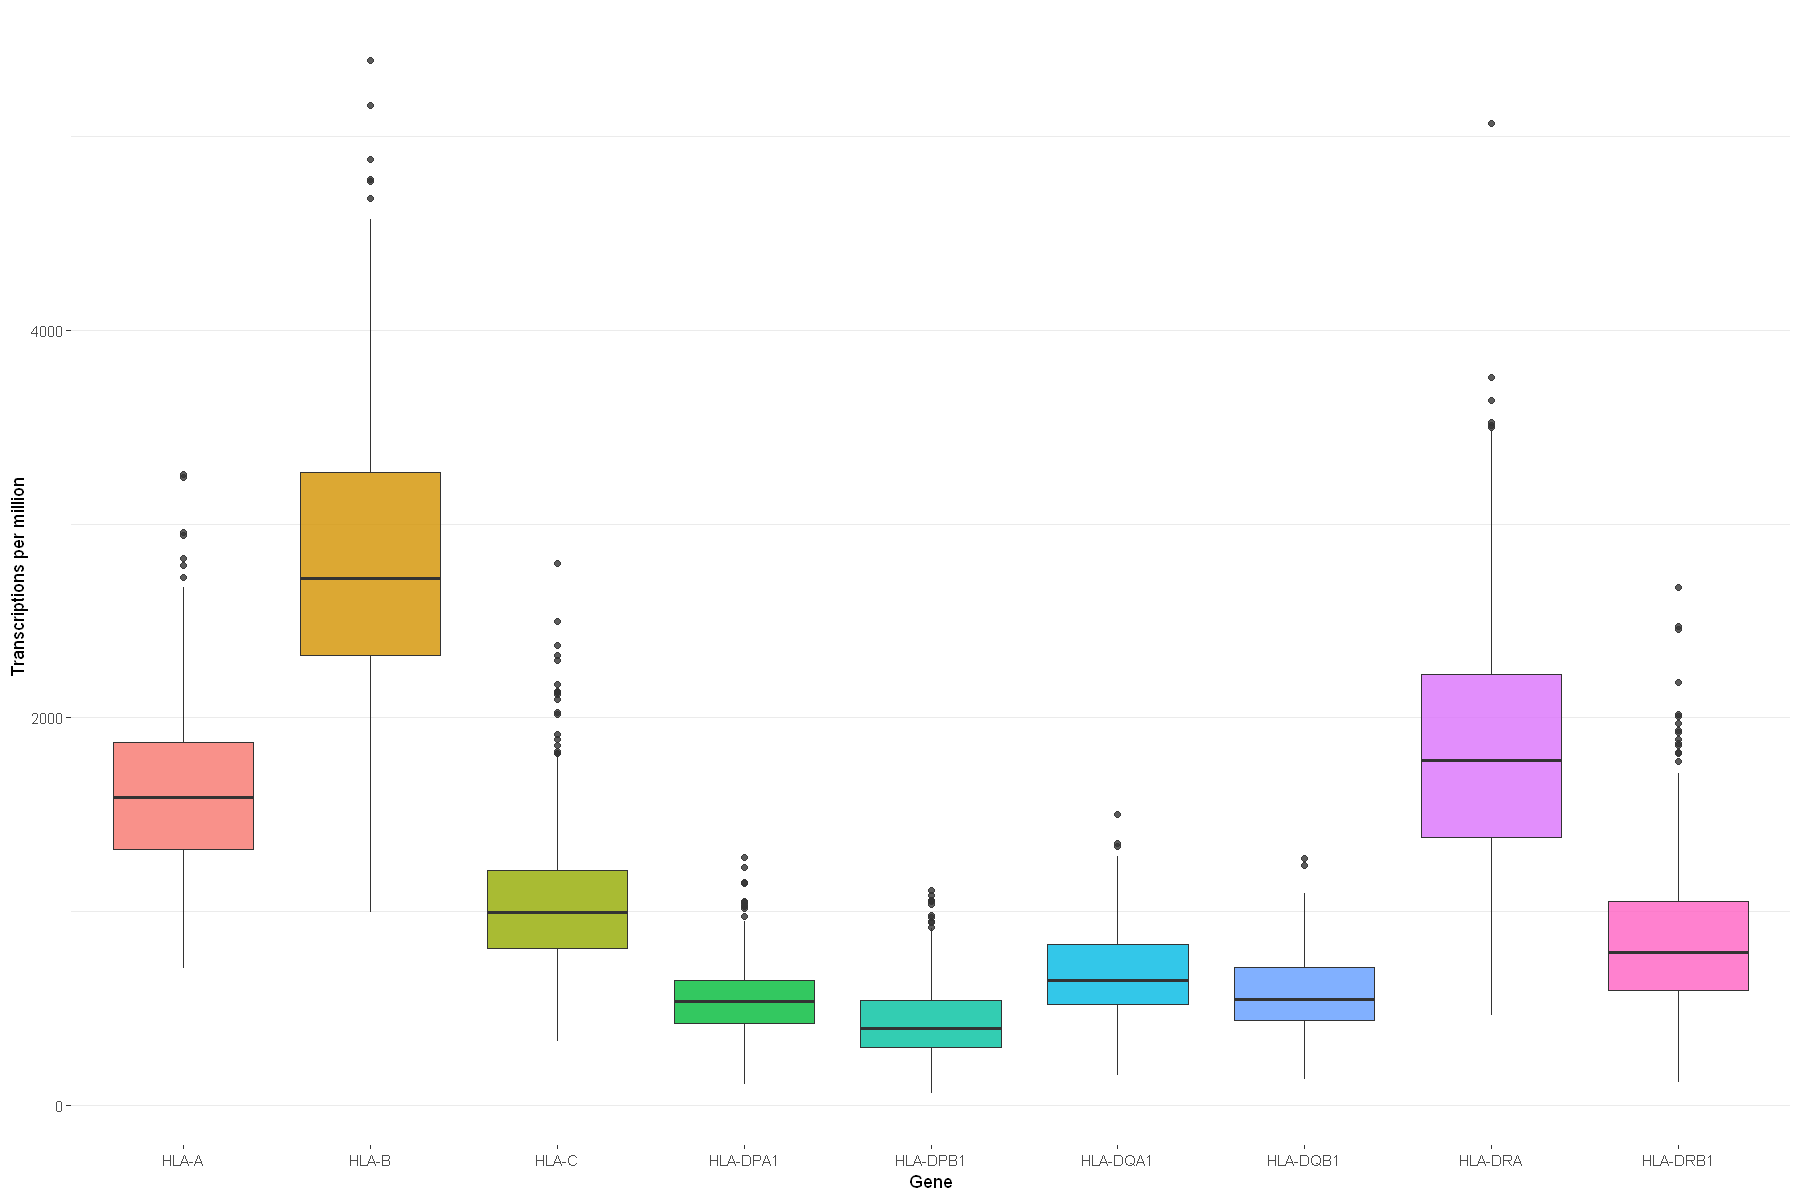

In [3]:
boxplotGenes = hlaExp %>% ggplot(aes(x = gene_name , y=tpm , fill = gene_name)) +
geom_boxplot(alpha = .8) +
theme_bw() +
theme( 
      legend.position='none',
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
labs(x = 'Gene',y= "Transcriptions per million" , fill = 'Gene')
boxplotGenes

# Symmetry plot

In [4]:
# List of all unique genes of interest
genesLoop = sort(unique(hlaExp$gene_name))
# Creating data frame to plot assymetry
dfSymmetryPhen = as.data.frame(NULL)
dfGreatesValues = as.data.frame(1:5)
idsHigher = c()

for( idx_ in 1:length(genesLoop) ){
    # For each gene:
    gene_ = genesLoop[idx_]
    # Filter gene associated information
    aux = hlaExp %>% filter(gene_name == gene_)
    # Selecting samples in top 10 tpm
    top10 = aux %>% arrange(-tpm) %>% mutate(n = 1:n()) %>% filter(n <= 10) %>% select(c('subject_id','tpm'))
    idsHigher = c(idsHigher,top10$subject_id)
    colnames(top10) = c(paste0(gene_,'_sample') , paste0(gene_,'_tpm'))
    dfGreatesValues = cbind(dfGreatesValues,top10)
    # Sort in ascending order gene expression (tpm)
    tpmSort = sort(aux$tpm)
    # Separate ordered set in two parts:
    # the 50% lower values - valuesInf
    #  and the 50% greater values - valuesSup
    # Then measure the distance to the median
    lengthSamp = length(tpmSort)
    sizeParts = round(lengthSamp/2)
    valuesInf = quantile(aux$tpm,.5) - tpmSort[1:sizeParts]
    valuesSup = tpmSort[seq(from = lengthSamp , to = (lengthSamp - sizeParts + 1))] - quantile(aux$tpm,.5)
    # create auxiliary df to append info
    dfAppend = as.data.frame(valuesInf)
    dfAppend$Sup_ = valuesSup
    dfAppend$gene_ = gene_
    # Append in final df
    dfSymmetryPhen = rbind(dfSymmetryPhen , dfAppend)
}
colnames(dfSymmetryPhen)[1] = 'Inf_'


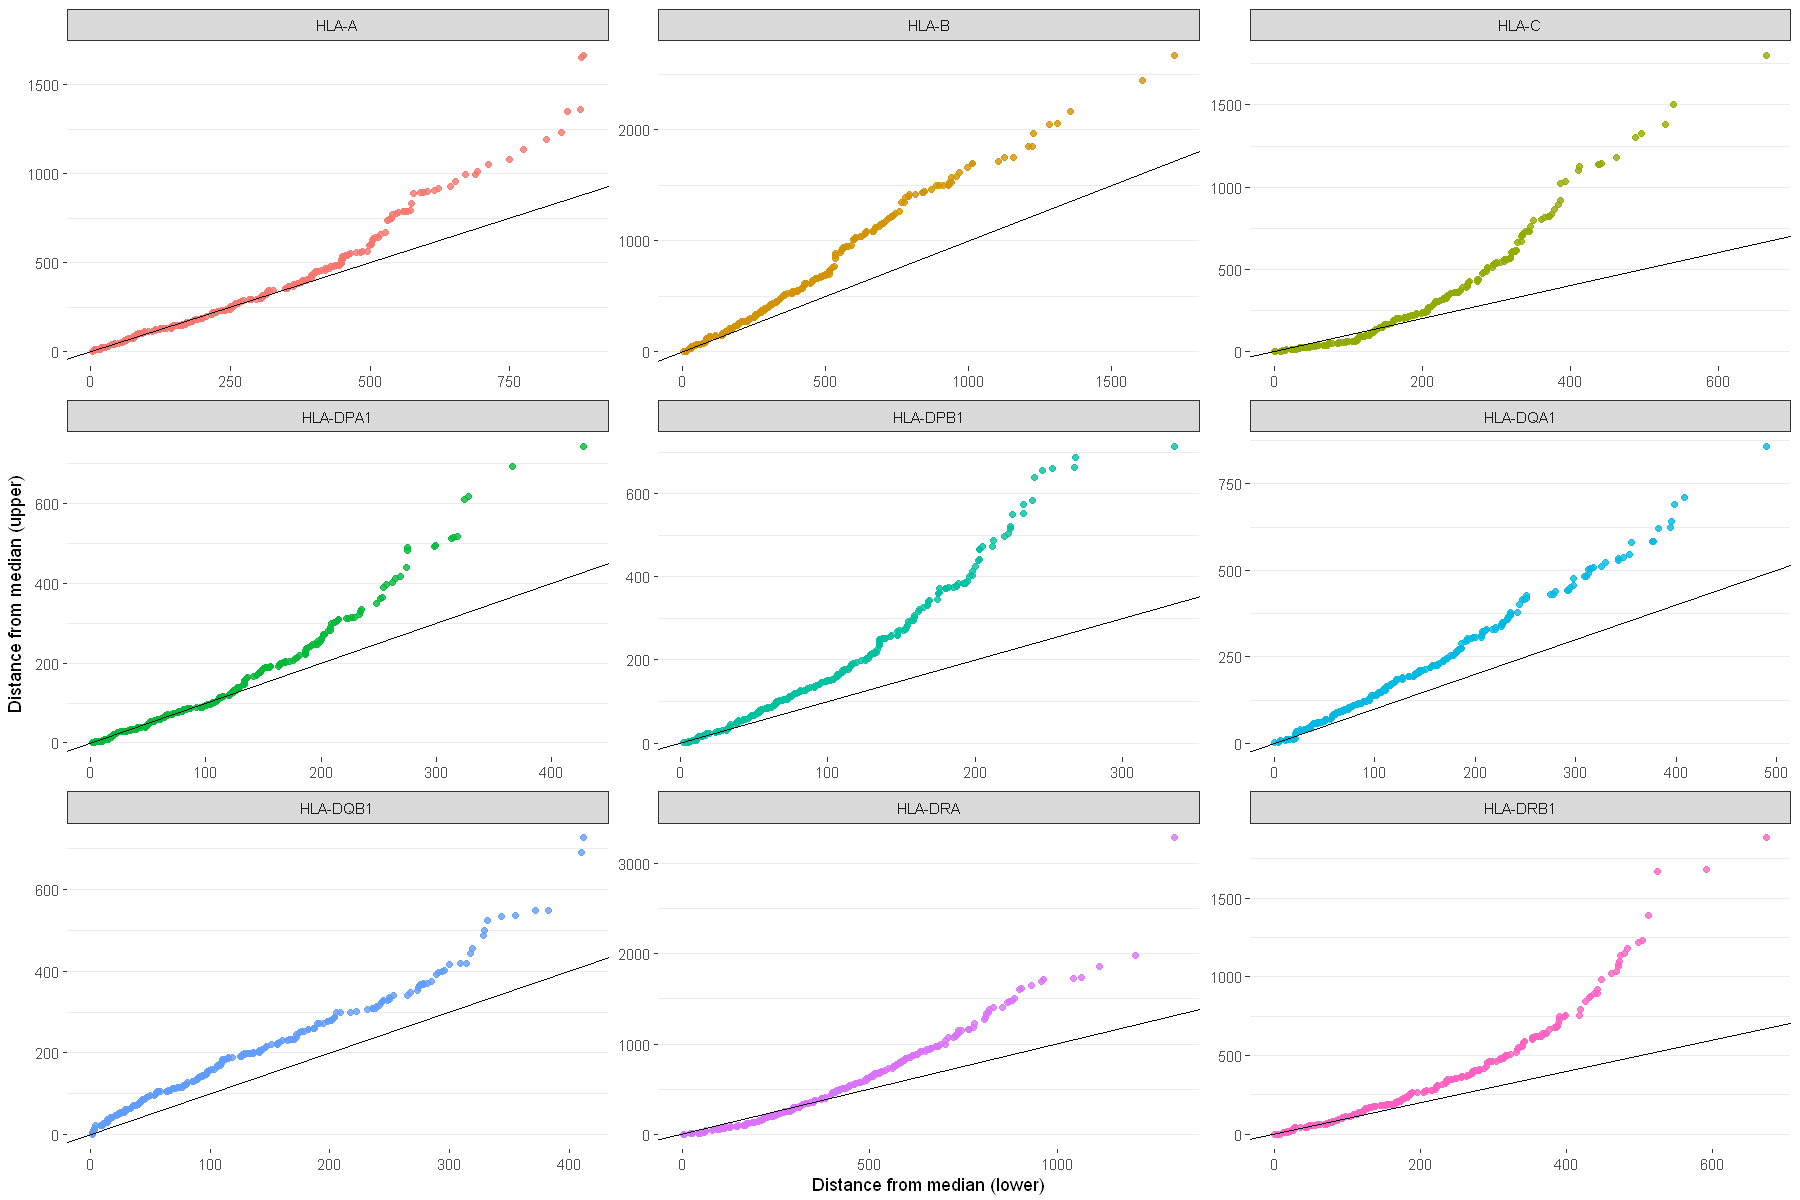

In [5]:
# Plot assymetry
plotSymmetry = dfSymmetryPhen %>% ggplot(aes(x = Inf_ , y = Sup_ , colour = gene_)) +
geom_point(alpha = .8) +
geom_abline(intercept = 0 , slope = 1) +
theme_bw() +
theme( 
      legend.position='none',
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
facet_wrap(~gene_ , scales = 'free')+
labs(x = "Distance from median (lower)" , y= 'Distance from median (upper)' , colour = 'Gene')
plotSymmetry

# Possible outliers (Multivariate)

In [6]:
confidenceBandsMahalanobis = function(n,qtTrials = 1000,idxInf = 25 , idxSup = 975){

    sample_ = matrix(0,n,qtTrials)
    limInf = numeric(n)
    limSup = numeric(n)
    #
    set.seed(9297791)
    for(i in 1:qtTrials){
        sample_[,i] = rchisq(n,df = 9)
        sample_[,i] = sort(sample_[,i]) 
        }
    #
    for(i in 1:n){
        quantiles_ = sort(sample_[i,])
        limInf[i]  = quantiles_[idxInf]
        limSup[i]  = quantiles_[idxSup]
        
        }
    return(list(limInf,limSup))
}

dfMahalanobis = function(horizontalExpDf,prob_=.993,df_=8){

    # Filter columns of interest - gene expressions and samples
    horizontalTpm = horizontalExpDf[,grepl('HLA|subject',colnames(horizontalExpDf))] 

    # Calculate means and covariance matrix
    meanExp = colMeans(horizontalTpm[,2:10])
    covExp = cov(horizontalTpm[,2:10])
    # Calculate Mahalanobis distance
    mahalanobisD = mahalanobis(horizontalTpm[,2:10],center = meanExp,cov = covExp)
    horizontalExpDf$Mahalanobis = mahalanobisD
    horizontalExpDf$idx = 1:nrow(horizontalExpDf)
    # Defining threshold on 99.9% chi-squared (9 df) quantile 
    cutMahalanobis = qchisq(prob_, df = df_)
    # Create dummy variable to define colours in the plot
    horizontalExpDf = horizontalExpDf %>% mutate(threshold = ifelse(Mahalanobis > cutMahalanobis , 'yes' , 'no'))

    return(horizontalExpDf)

}

plotMahalanobis = function(horizontalExpDf,prob_=.993,df_=8){

    cutMahalanobis = qchisq(prob_, df = df_)
    # Plot Mahalanobis Distance by index
    plotMahalanobis = horizontalExpDf %>% 
    ggplot(aes(x = idx , y = Mahalanobis , colour =  threshold)) +
    geom_point() +
    geom_hline(yintercept=cutMahalanobis) +
    ggrepel::geom_text_repel(data=subset(horizontalExpDf, Mahalanobis > cutMahalanobis), max.overlaps = 50,
                aes(idx,Mahalanobis,label=subject_id)) +
    theme_bw() +
    theme( 
        legend.position='none',
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
        )

    return(plotMahalanobis)

}
# ggsave(paste0(rootSave,'mahalanobis',".png"), plotMahalanobis, bg = "transparent",width=10, height=8, dpi=300)

plotMahalanobisQQ = function(horizontalExpDf,prob_=.993,df_=9){

    cutMahalanobis = qchisq(prob_, df = df_)
    # Sorting Mahalanobis values
    dfOrderedMahalanobis = as.data.frame( sort ( horizontalExpDf$Mahalanobis) )
    # Defining quantile values to compare with Chi-squared distribution
    dfOrderedMahalanobis$idx = ((1:nrow(dfOrderedMahalanobis)) - .5)/nrow(dfOrderedMahalanobis)
    dfOrderedMahalanobis$chisqQ = qchisq(dfOrderedMahalanobis$idx, df = df_)
    # Selecting only observed mahalanobis and expected chi-squared value
    dfOrderedMahalanobisPlt = dfOrderedMahalanobis[,c(1,3)]
    colnames(dfOrderedMahalanobisPlt) = c('Observed','Expected')
    # Label high values
    dfOrderedMahalanobisPlt = dfOrderedMahalanobisPlt %>% mutate(Threshold = ifelse(Observed > cutMahalanobis , 'yes' , 'no'))

    # Creating confidence bands
    intervalFull = confidenceBandsMahalanobis(n = nrow(dfOrderedMahalanobisPlt) , idxInf = 50 , idxSup = 9950 , qtTrials = 10000)
    dfOrderedMahalanobisPlt$LimInf = intervalFull[[1]]
    dfOrderedMahalanobisPlt$LimSup = intervalFull[[2]]

    # Quantile-quantile plot - comparing Mahalanobis distance with Chi-squared distribution
    plotQQFull = dfOrderedMahalanobisPlt %>% 
    ggplot() +
    geom_point( aes ( x = Expected , y = Observed , colour = Threshold) ) +
    geom_line ( aes ( x = Expected , y = LimInf ) , linetype = 2 , colour = 'red' ) +
    geom_line ( aes ( x = Expected , y = LimSup ) , linetype = 2 , colour = 'red' ) +
    geom_abline( slope = 1 , intercept = 0 ) +
    theme_bw() +
    theme( 
        legend.position='none',
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
        ) 

    return(plotQQFull)
    
}

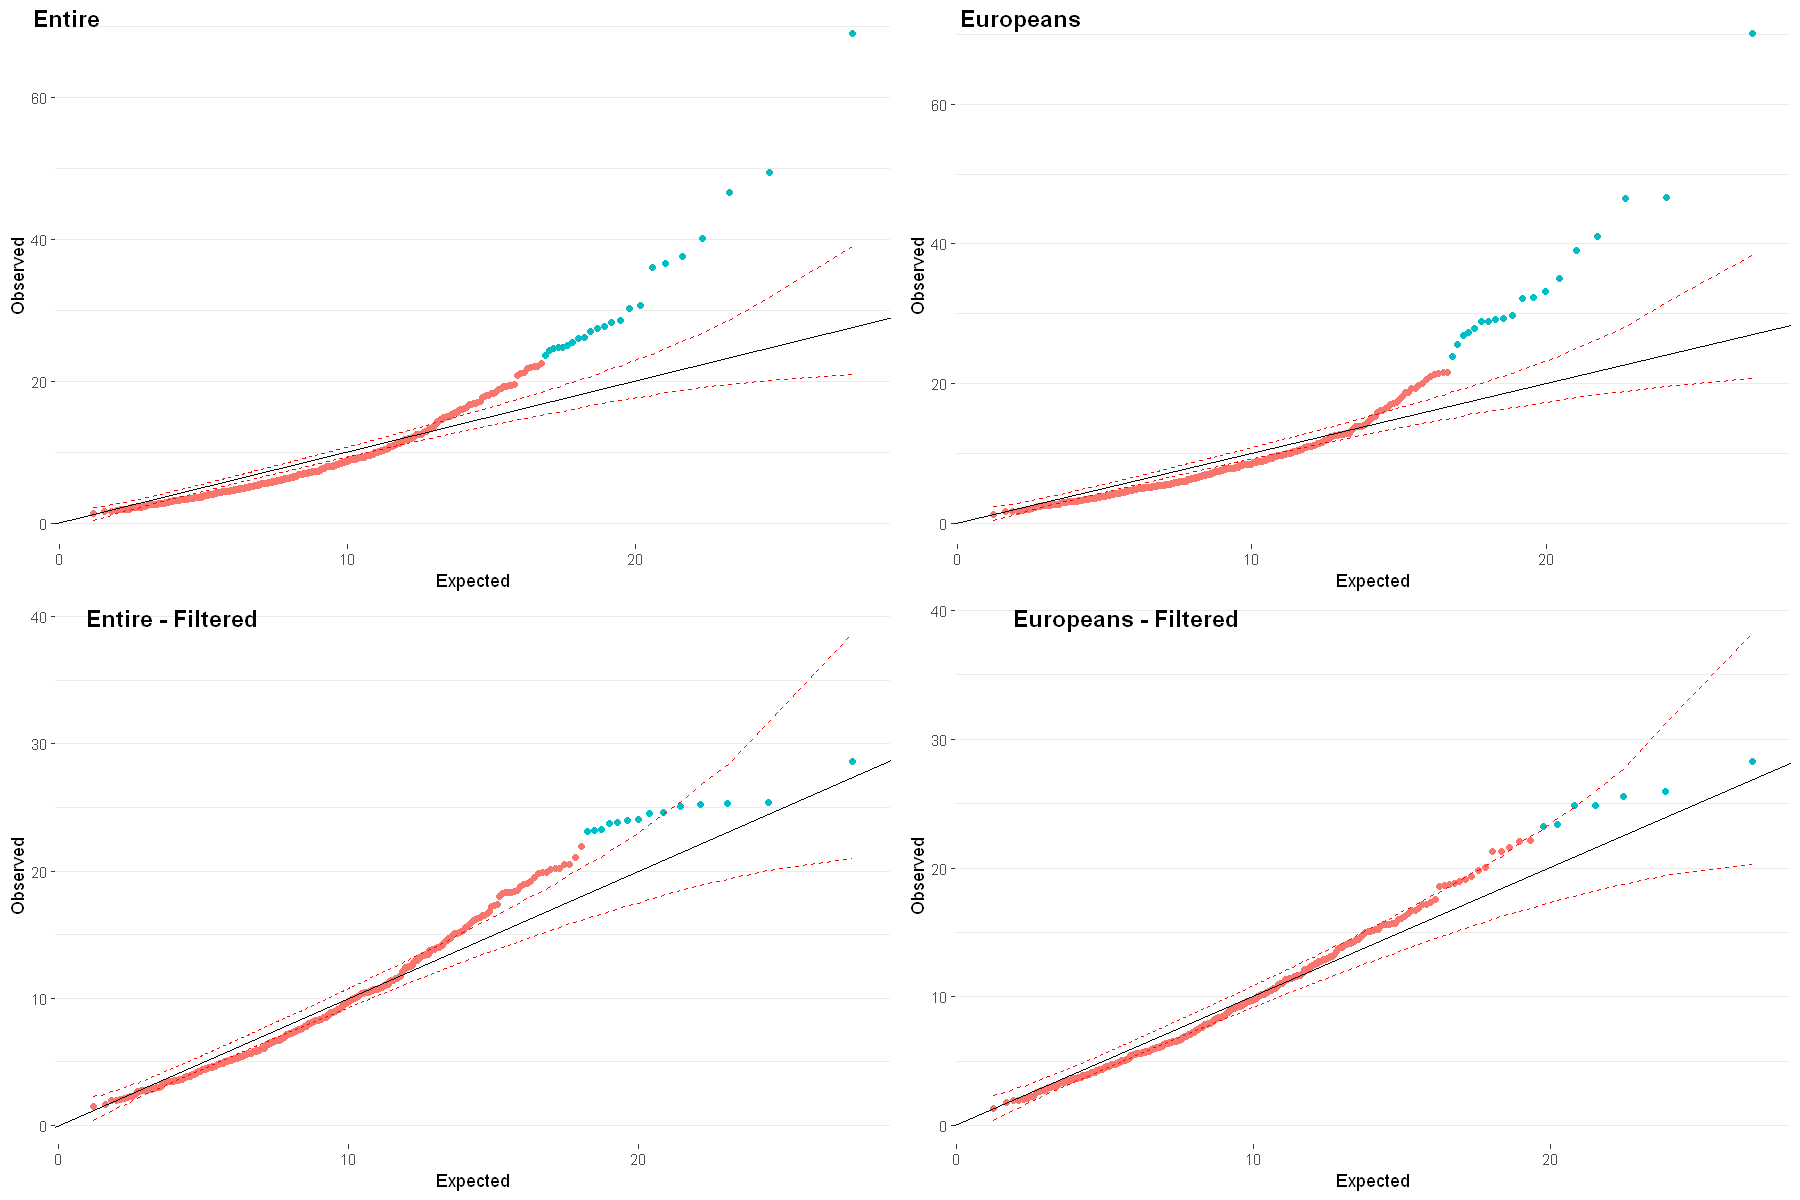

In [7]:
# Transforming original dataset in horizontal position to analyse
dfMahalanobisAnalysis = tidyr::spread(hlaExp,gene_name,tpm)
dfMahalanobisEurAnalysis = tidyr::spread(hlaExp,gene_name,tpm) %>% filter(pop != 'YRI')
# Mahalanobis with all available data
dfMahalanobisFull = dfMahalanobis(dfMahalanobisAnalysis)
# Mahalanobis, excluding possible outliers
dfMahalanobisOut = dfMahalanobis(dfMahalanobisFull %>% filter(threshold == 'no'))
# Mahalanobis with only europeans
dfMahalanobisEur = dfMahalanobis(dfMahalanobisEurAnalysis)
# Mahalanobis with only europeans, excluding possible outliers
dfMahalanobisEurOut = dfMahalanobis(dfMahalanobisEur %>% filter(threshold == 'no'))

p11 = plotMahalanobisQQ(dfMahalanobisFull)
p12 = plotMahalanobisQQ(dfMahalanobisEur)
p21 = plotMahalanobisQQ(dfMahalanobisOut)
p22 = plotMahalanobisQQ(dfMahalanobisEurOut)

pltMahalanobis = ggpubr::ggarrange( 
                    p11, p12, p21 , p22 ,
                    labels = c("Entire", "Europeans",'Entire - Filtered','Europeans - Filtered'),
                    ncol = 2, nrow = 2
                    )
pltMahalanobis

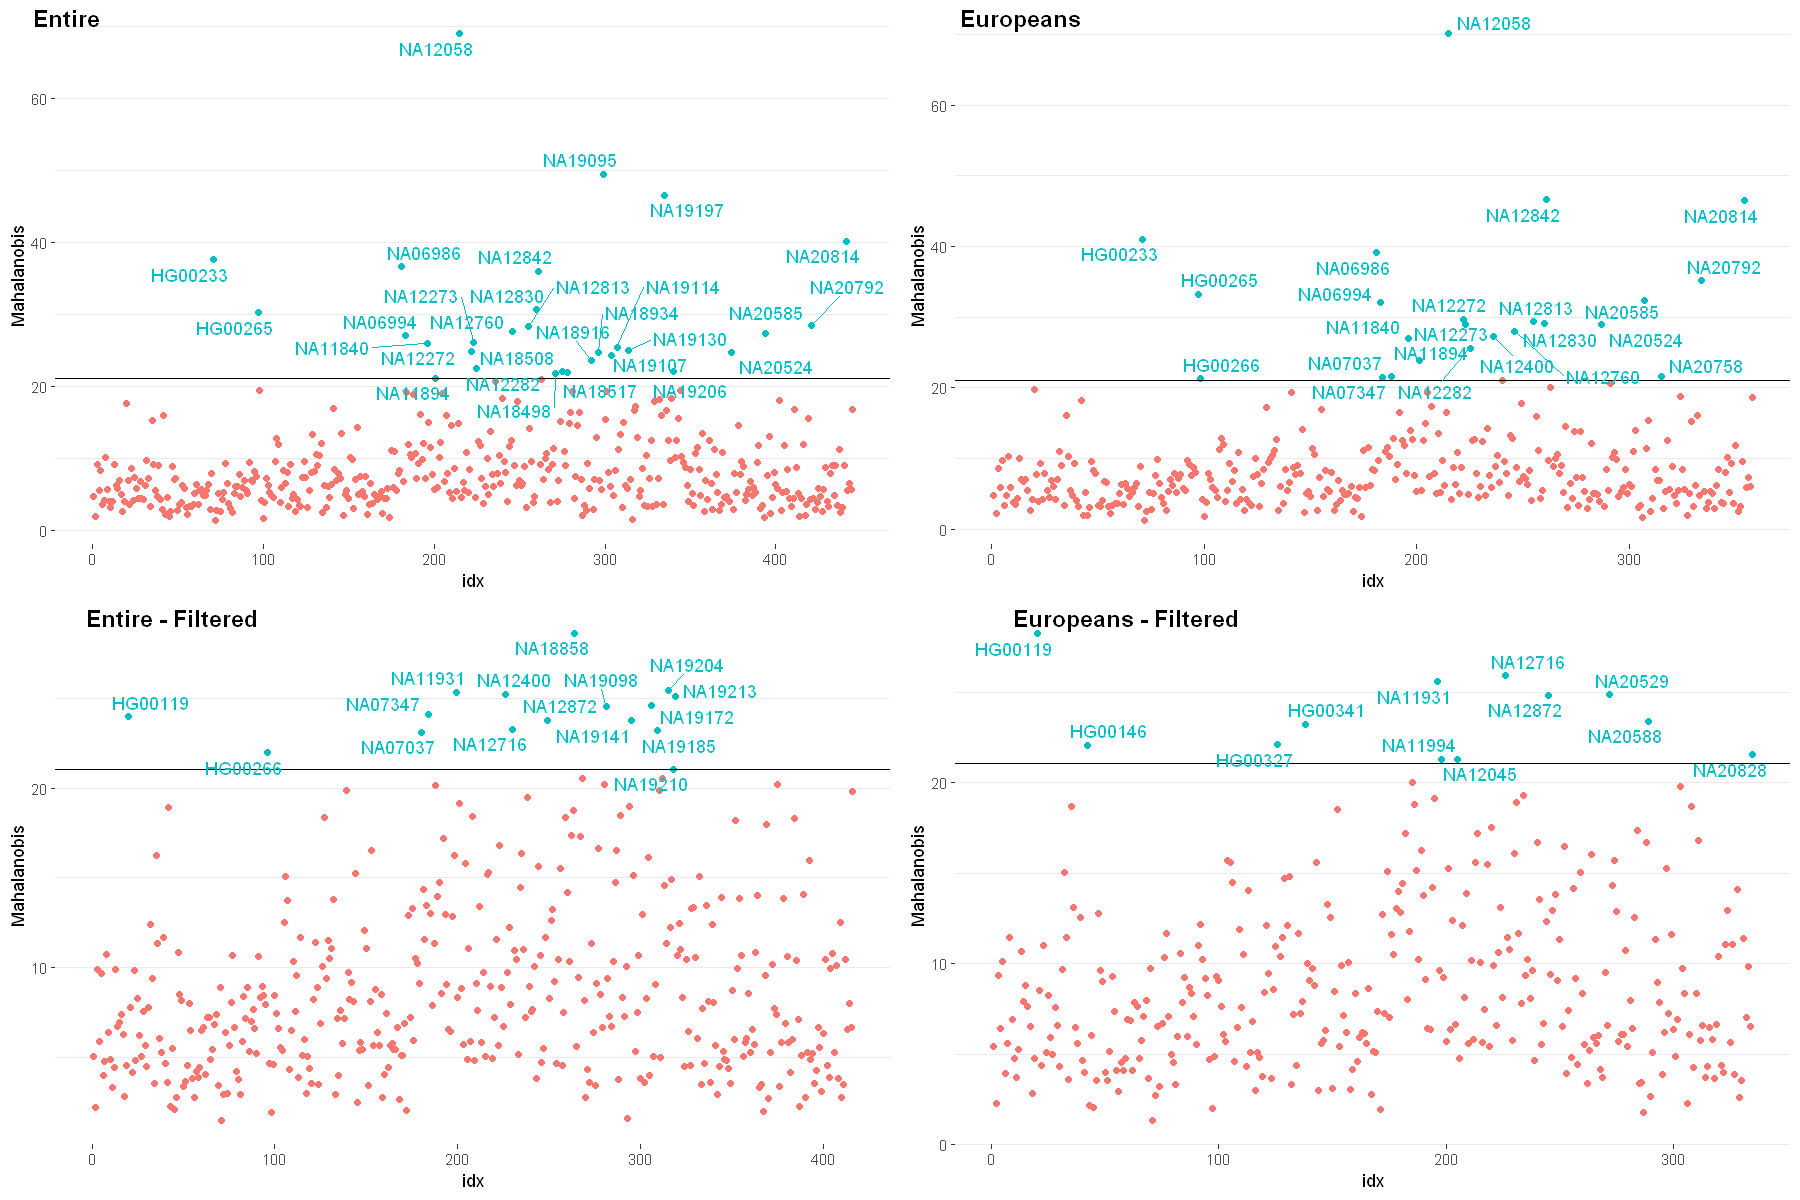

In [8]:
p11 = plotMahalanobis(dfMahalanobisFull)
p12 = plotMahalanobis(dfMahalanobisEur)
p21 = plotMahalanobis(dfMahalanobisOut)
p22 = plotMahalanobis(dfMahalanobisEurOut)

pltMahalanobis = ggpubr::ggarrange( 
                    p11, p12, p21 , p22 ,
                    labels = c("Entire", "Europeans",'Entire - Filtered','Europeans - Filtered'),
                    ncol = 2, nrow = 2
                    )
pltMahalanobis

# Biplot

In [ ]:
biplotPlt = function(covars_,sampleId_,cor_,dfThreshold_,scaleBip) {

    biplotFit = princomp(x = covars_, cor = cor_)
    biplotDf = data.frame(sampleid = sampleId_ , biplotFit$scores)
    # Merge df with dummy variable based on Mahalanobis distance and threshold
    biplotDf = merge(biplotDf,dfThreshold_)
    pcLoads = data.frame(biplotFit$loadings[,1:9])
    
    # Plot biplot
    plotBiplot = biplotDf %>% ggplot() + 
    geom_text(data=subset(biplotDf, threshold == 'yes'),
                aes(Comp.1,Comp.2,label=sampleid,colour = threshold),alpha = .7) +
    geom_text(data=subset(biplotDf, threshold == 'no'),
                aes(Comp.1,Comp.2,label=sampleid,colour = threshold),alpha = .5) +
    geom_hline(yintercept = 0, size=.2) + 
    geom_vline(xintercept = 0, size=.2) +
    theme_bw() +
    theme( 
        legend.position='none',
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
        ) +
    geom_segment(data = pcLoads , aes(x=0, y=0,xend = scaleBip*Comp.1 , yend = scaleBip*Comp.2), arrow=arrow(length=unit(0.1,"cm")), alpha=0.75) +
    ggrepel::geom_text_repel(data = pcLoads , aes(x=scaleBip*Comp.1, y=scaleBip*Comp.2, label=row.names(pcLoads) , size = 5, vjust=1) ) +
    geom_text(data = pcLoads , aes(x=scaleBip*Comp.1, y=scaleBip*Comp.2, label=row.names(pcLoads) , size = 5, vjust=1) ) +
    labs(x = 'Principal Component 1' , y = 'Principal Component 2')

    return( plotBiplot )

}
# horizontalTpm[,2:10] = scale(horizontalTpm[,2:10],center = T , scale = T)
# Create biplot - PCA for XX'and X'X

covarsFull_ = dfMahalanobisAnalysis[,grepl('HLA',colnames(dfMahalanobisAnalysis))]
sampleFull_ = dfMahalanobisAnalysis[,grepl('subject',colnames(dfMahalanobisAnalysis))] 
pltFull = biplotPlt( covars_ = covarsFull_ , sampleId_ = sampleFull_ , cor_ = FALSE , dfThreshold_ = dfMahalanobisFull[,c('subject_id','threshold')] , scaleBip = 2500)
pltFull


In [11]:
covarsFull_ = dfMahalanobisAnalysis[,grepl('HLA',colnames(dfMahalanobisAnalysis))]
sampleFull_ = dfMahalanobisAnalysis[,grepl('subject',colnames(dfMahalanobisAnalysis))] 

biplotFit = princomp(x = covarsFull_, cor = FALSE)
biplotDf = data.frame(sampleid = sampleFull_ , biplotFit$scores)
# Merge df with dummy variable based on Mahalanobis distance and threshold
biplotDf = merge(biplotDf,dfMahalanobisFull[,c('subject_id','threshold')])
pcLoads = data.frame(biplotFit$loadings[,1:9])


In [13]:
biplotDf

sampleid,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8,Comp.9,subject_id,threshold
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
HG00096,-303.3457,690.91494,-53.576000,-82.97025,-4.056544,258.8496354,74.328771,26.550016,-38.53654,HG00096,no
HG00097,-601.8450,289.05824,-58.096225,-32.24281,-138.891142,-46.9795303,96.692517,22.010546,-11.21462,HG00096,no
HG00099,-2217.2609,387.22619,159.668928,-203.54695,-60.458175,177.8837591,-26.930115,41.966305,54.15957,HG00096,no
HG00100,-289.2612,1064.10463,-319.699509,-169.27383,-131.160115,158.1546521,14.636773,-15.482510,23.38226,HG00096,no
HG00101,-631.5580,1000.06098,-645.964264,-157.96556,-48.116395,-26.8646081,72.775210,-21.733622,-35.09442,HG00096,no
HG00102,-1385.3925,73.61722,54.722413,-129.89590,-160.074413,51.9027017,-15.228511,50.079756,13.85699,HG00096,no
HG00103,-250.1690,116.42247,239.387493,61.97550,96.362526,-145.7470337,-167.151624,49.268111,-9.89156,HG00096,no
HG00105,-753.5402,1101.32450,411.530787,341.40682,-37.895784,239.4218804,4.722830,82.269112,33.08494,HG00096,no
HG00106,-869.4936,195.40979,217.920372,-199.08529,-275.186593,203.4125777,-28.518959,55.897509,-16.06525,HG00096,no
